Universidade Federal de Santa Catarina<br>
Departamento de Engenharia Elétrica e Eletrônica<br>
EEL7514/EEL7513 - Introdução ao Aprendizado de Máquina
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bA}{\mathbf{A}}$
$\newcommand{\bZ}{\mathbf{Z}}$
$\newcommand{\bdelta}{\boldsymbol{\delta}}$
$\newcommand{\bDelta}{\boldsymbol{\Delta}}$
$\newcommand{\mat}[1]{\begin{bmatrix} #1 \end{bmatrix}}$


# Exercício 5: Redes Neurais - Treinamento


Neste exercício você irá implementar a construção e treinamento de rede neural genérica, como qualquer número de camadas e qualquer número de unidades por camada. Em seguida você irá usar o código desenvolvido em um problema de classificação de imagens.

Lembre que, além da implementação, você deve incluir também uma **análise** dos resultados. 

# 1. Obtendo o conjunto de dados

O conjunto de dados será formado por imagens de gatos ($y=1$) e não-gatos ($y=0$), cada uma com 64x64x3 pixels (3 canais RGB), com valores de intensidade inteiros entre 0 e 255. As imagens já estão separadas em um conjunto de treinamento com 209 amostras e um conjunto de teste com 50 amostras.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

train_data = h5py.File('datasets/train_catvnoncat.h5', "r")
train_images = train_data["train_set_x"][:]
train_labels = train_data["train_set_y"][:]
test_data = h5py.File('datasets/test_catvnoncat.h5', "r")
test_images = test_data["test_set_x"][:]
test_labels = test_data["test_set_y"][:]

print(train_images.shape)
print(test_images.shape)
print(train_images.min())
print(train_images.max())

(209, 64, 64, 3)
(50, 64, 64, 3)
0
255


1


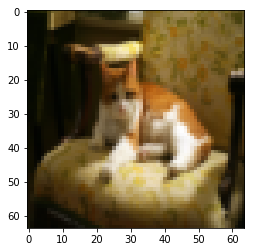

In [2]:
# Exemplo de uma imagem
index = 7
plt.imshow(train_images[index])
print(train_labels[index])

Como cada conjunto de dados é um array 4-D com dimensões $m \times 64 \times 64 \times 3$, devemos primeiramente convertê-los em uma matriz de atributos com dimensões $m \times 12288$. Além disso, é uma boa prática normalizar os dados, o que, nesse caso, pode ser feito simplesmente dividindo-se cada atributo por 255, de forma que cada atributo esteja na faixa [0,1].

In [3]:
m_train = train_images.shape[0]
X_train = train_images.reshape(m_train,-1)/255
Y_train = train_labels.reshape(m_train,-1)

m_test = test_images.shape[0]
X_test = test_images.reshape(m_test,-1)/255
Y_test = test_labels.reshape(m_test,-1)

# 2. Estrutura do modelo

Os parâmetros do modelo são:
- Número de camadas, $L$ (excluindo-se a camada de entrada)
- Número de unidades por camada, $n_0,\ldots,n_L$, representados por uma tuple `n` de comprimento $L+1$. Ex: `n[0] = 12288`. Como é um problema de classificação binária, necessariamente o último elemento tem valor `n[L] = 1`.
- Matrizes de pesos, $\bW^{[1]},\ldots,\bW^{[L]}$, sendo que $\bW^{[\ell]}$ possui tamanho $n_{\ell} \times n_{\ell-1}$. Para facilitar, represente-as por uma **lista** `W` de comprimento $L+1$, sendo que o primeiro elemento deve ser ignorado; por exemplo, defina `W[0] = None`.
- Vetores de bias, , $\bb^{[1]},\ldots,\bb^{[L]}$, sendo que $\bb^{[\ell]}$ possui tamanho $n_{\ell} \times 1$. Da mesma forma, represente-os por uma lista `b` de comprimento $L+1$, com `b[0] = None`.

Utilize funções de ativação sigmóide logística, $g(z)=σ(z)$, tanto na camada de saída quanto nas camadas ocultas, e a função custo de entropia cruzada.

Para uso nas funções de otimização, os parâmetros $\bW^{[\ell]}$ e $\bb^{[\ell]}$ devem estar representados como um único vetor 1-D, denotado por $\theta$, o qual deve possuir comprimento $N = \prod_{\ell=1}^L (n_{\ell-1}+1)n_\ell$.

**Dica:** Defina `n` fora do escopo das funções, i.e., no escopo principal. Desta forma seu valor estará disponível para leitura dentro das funções, como uma variável global.

**Dica:** Inspecione com cuidado as funções abaixo, as quais já foram (parcialmente) fornecidas.

In [4]:
def merge_parameters(W, b):
    theta = np.concatenate([np.concatenate([W[i].reshape(-1),b[i].reshape(-1)]) for i in range(1,len(W))])
    return theta

def split_parameters(theta):
    W = [None]*len(n)
    b = [None]*len(n)
    j = 0
    for i in range(1,len(n)):
        W[i] = theta[j:j+n[i]*n[i-1]].reshape(n[i],n[i-1])
        j = j+n[i]*n[i-1]
        b[i] = ?
        j = ?
    return W, b

# 3. Treinamento

O treinamento da rede neural, implementado pela função `train` fornecida abaixo, envolve os seguintes passos:

1. Inicialização dos parâmetros (vetor $\theta$)
2. Minimização da função custo

Os pesos W devem ser inicializados com valores aleatórios pequenos, por exemplo, variáveis gaussianas com média nula e desvio padrão 1e-2. 

A minimização será realizada usando a função `minimize` com o método do gradiente conjugado (`method = 'CG'`). Não utilize o método padrão do SciPy pois ele é ineficiente para as dimensões desse problema.

A implementação da função custo envolve:
- Propagação direta para encontrar as matrizes $\bA^{[\ell]}$ e $\bZ^{[\ell]}$
- Cálculo do custo J
- Propagação reversa para encontrar as matrizes $\bDelta^{[\ell]}$, $dJ/d\bW^{[\ell]}$, $dJ/d\bb^{[\ell]}$

Lembre-se que todas estas matrizes possuem $m$ colunas, i.e., são formadas pela concatenação horizontal dos vetores correspondentes ao longo das amostras de treinamento.

Note que uma implementação vetorizada, i.e., usando matrizes e operações com matrizes ao invés de laços `for`, é imprescindível para garantir um treinamento eficiente. Por outro lado, em quaisquer das duas propagações, ainda será necessário iterar ao longo das camadas, uma vez existe uma dependência entre elas.

Caso necessário, utilize a checagem de gradiente (aproximação via diferenças finitas) para confirmar que a sua implementação está correta.

1. Treine uma rede neural com $L=2$ camadas, com $n_1$ à sua escolha, e reporte sua acurácia no conjunto de treinamento e no conjunto de teste.
2. Introduza regularização $\ell_2$ ao treinamento e repita o item anterior.

Seu objetivo para esta questão é obter pelo menos **72% de acurácia** no conjunto de teste. Fique à vontade para experimentar alterar os parâmetros do modelo e do treinamento até obter um bom desempenho.

In [5]:
def train(X, Y, lamb=0):
    import scipy.optimize as opt
    theta = initialize_parameters()
    theta = opt.minimize(fun=cost, x0=theta, method='CG', jac=True, args=(X,Y,lamb), options={'maxiter': 1000, 'disp': True}).x
    return theta

def initialize_parameters():
    return theta

def cost(theta, X, Y, lamb):    
    W, b = split_parameters(theta)

    # Forward propagation
 
    # Compute cost
        
    # Backpropagation
    
    grad = merge_parameters(dJ_dW, dJ_db)    
    return J, grad

def predict_class(theta, X):    
    W, b = split_parameters(theta)
    
    # Forward propagation
    
    Y_pred = (Y_hat > 0.5).astype(float)
    return Y_pred

def accuracy(theta, X, Y):
    Y_pred = predict_class(theta, X)
    return np.mean(Y_pred == Y)

In [6]:
n = (X_train.shape[1], ?, ?)
lamb = 0

In [7]:
np.random.seed(0)

In [8]:
theta = train(X_train,Y_train,lamb)
print('Train accuracy:', accuracy(theta,X_train,Y_train)*100, '%')
print('Test accuracy:', accuracy(theta,X_test,Y_test)*100, '%')

Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 254
         Function evaluations: 598
         Gradient evaluations: 598
Train accuracy: 100.0 %
Test accuracy: 70.0 %


Você experimentou usar um número grande ($L>2$) de camadas, i.e., uma rede profunda? O que você observou?

# 4. Implementação via biblioteca padrão

Agora, refaça o exercício usando a biblioteca `scikit-learn`. Assim como antes, seu objetivo é obter **72% de acurácia** no conjunto de teste.

In [9]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=?, alpha=?, max_iter=?, activation='logistic', solver='lbfgs', random_state=0)

Train accuracy: 100.0 %
Test accuracy: 70.0 %


# 5. (OPCIONAL) Questões avançadas

1. Escolha um outro conjunto de dados da sua preferência e tente classificá-lo usando uma rede neural. Ex:
```python
mnist = sklearn.datasets.fetch_mldata('MNIST original', data_home='./data')
```
2. Generalize sua implementação para permitir funções de ativação diferentes nas camadas ocultas e na camada de saída. Experimente a função de ativação ReLU nas camadas ocultas e verifique se consegue melhorar o desempenho.
2. Implemente o método do gradiente mini-batch.
3. Implemente e treine uma rede neural para classificação multi-classe com a função de ativação softmax e o custo de entropia cruzada categórica.